# **Question 3: Modified Barabasi-Albert Model**

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generalized_barabasi_albert(initial_nodes, final_nodes, edges_per_step, alpha=1.0):
    G = nx.complete_graph(initial_nodes)

    for i in range(initial_nodes, final_nodes):
        nodes = list(G.nodes())
        degrees = [G.degree(node) for node in nodes]
        weighted_degrees = [degree**alpha for degree in degrees]
        total_weighted_degree = sum(weighted_degrees)

        if total_weighted_degree == 0: probabilities = [1.0/len(nodes) for _ in nodes]  # Uniform if all degrees are 0
        else: probabilities = [w_degree / total_weighted_degree for w_degree in weighted_degrees]

        if edges_per_step >= len(nodes): targets = nodes
        else: targets = np.random.choice(nodes, size=edges_per_step, replace=False, p=probabilities)

        G.add_node(i)
        for target in targets:
            G.add_edge(i, target)
    
    return G

def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(sorted_x)
    cumsum = np.cumsum(sorted_x)
    return (n + 1 - 2 * np.sum(cumsum) / (cumsum[-1])) / n if cumsum[-1] > 0 else 0

In [3]:
def analyze_network(G):
    results = {}

    results['nodes'] = G.number_of_nodes()
    results['edges'] = G.number_of_edges()
    results['avg_clustering'] = nx.average_clustering(G)

    degrees = [G.degree(n) for n in G.nodes()]
    results['max_degree'] = max(degrees)
    results['avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()
    results['degree_variance'] = np.var(degrees)
    results['gini_coefficient'] = gini_coefficient(degrees)

    degree_counts = Counter(degrees)
    results['degree_distribution'] = degree_counts
    
    if nx.is_connected(G):
        results['char_path_length'] = nx.average_shortest_path_length(G)
        results['network_diameter'] = nx.diameter(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        largest_subgraph = G.subgraph(largest_cc)
        results['char_path_length'] = nx.average_shortest_path_length(largest_subgraph)
        results['network_diameter'] = nx.diameter(largest_subgraph)
        results['largest_component_ratio'] = len(largest_cc) / G.number_of_nodes()
    
    # Power law fit
    try:
        unique_degrees = sorted(set(degrees))
        counts = [degree_counts[d] for d in unique_degrees]
        pk = [c/sum(counts) for c in counts]  # Convert to probability
        
        valid_indices = [i for i, p in enumerate(pk) if p > 0]
        valid_k = [unique_degrees[i] for i in valid_indices]
        valid_pk = [pk[i] for i in valid_indices]
        
        if len(valid_k) > 5:
            log_k = np.log(valid_k)
            log_pk = np.log(valid_pk)
            coeffs = np.polyfit(log_k, log_pk, 1)
            results['power_law_exponent'] = -coeffs[0]
        else:
            results['power_law_exponent'] = None
    except:
        results['power_law_exponent'] = None
    
    # Centralization metrics
    try:
        degree_centrality = nx.degree_centrality(G)
        max_centrality = max(degree_centrality.values())
        sum_diff = sum(max_centrality - c for c in degree_centrality.values())
        n = G.number_of_nodes()
        normalization = (n-1)*(n-2)/(n-1)
        results['degree_centralization'] = sum_diff / normalization if normalization > 0 else 0
    except:
        results['degree_centralization'] = None
    
    # Assortativity coefficient (degree correlation)
    try:
        results['assortativity'] = nx.degree_assortativity_coefficient(G)
    except:
        results['assortativity'] = None
    
    return results

In [4]:
def plot_degree_distribution(degree_counts, alpha, filename=None):
    degrees = sorted(degree_counts.keys())
    counts = [degree_counts[d] for d in degrees]
    total_nodes = sum(counts)

    ccdf = []
    for d in degrees:
        nodes_with_degree_geq_d = sum(count for deg, count in degree_counts.items() if deg >= d)
        ccdf.append(nodes_with_degree_geq_d / total_nodes)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(degrees, ccdf, 'bo-', markersize=6, alpha=0.7, label='CCDF P(k≥x)')
    
    if len(degrees) > 5 and min(degrees) > 0:
        log_k = np.log(degrees)
        log_ccdf = np.log(ccdf)
        coeffs = np.polyfit(log_k, log_ccdf, 1)
        gamma = -coeffs[0]

        x_range = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 100)
        y_fit = np.exp(coeffs[1]) * x_range**coeffs[0]
        plt.loglog(x_range, y_fit, 'r-', label=f'Power law fit: γ≈{gamma:.2f}')
    
    plt.xlabel('Degree k (log scale)')
    plt.ylabel('P(K ≥ k) (log scale)')
    plt.title(f'Degree Distribution (CCDF) with α={alpha:.1f}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    if filename:
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def visualize_network(G, alpha, filename=None):
    if G.number_of_nodes() > 150:
        nodes = sorted(G.nodes())
        sampled_nodes = sorted(np.random.choice(nodes, 150, replace=False))
        G_vis = G.subgraph(sampled_nodes)
    else:
        G_vis = G

    fig, ax = plt.subplots(figsize=(12, 10))
    pos = nx.spring_layout(G_vis, k=0.2, seed=42)

    degrees = dict(G_vis.degree())
    max_degree = max(degrees.values()) if degrees else 1
    node_sizes = [20 + 1000 * (degrees[node] / max_degree) for node in G_vis.nodes()]
    node_colors = [degrees[node] for node in G_vis.nodes()]
    
    nodes = nx.draw_networkx_nodes(
        G_vis, pos, 
        node_size=node_sizes, 
        node_color=node_colors,
        cmap=plt.cm.viridis,
        alpha=0.7,
        ax=ax
    )
    
    nx.draw_networkx_edges(
        G_vis, pos,
        edge_color='gray',
        width=0.3,
        alpha=0.5,
        ax=ax
    )
    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Node Degree')
    
    plt.title(f'Network with α={alpha:.1f} (N={G.number_of_nodes()}, m={G.number_of_edges()/G.number_of_nodes():.1f})')
    plt.axis('off')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

In [5]:
def run_experiments(final_nodes=1000, initial_nodes=10, edges_per_step=3, runs_per_model=10):
    # Alpha values to test (1.0 is standard BA, 2.0 is square, 3.0 is cube, etc.)
    alpha_values = [1.0, 2.0, 3.0, 4.0]
    results = []
    example_networks = {}
    
    for alpha in alpha_values:
        print(f"Running experiments with alpha={alpha}...")
        
        for run in tqdm(range(runs_per_model)):
            G = generalized_barabasi_albert(initial_nodes, final_nodes, edges_per_step, alpha)
            if run == 0: example_networks[alpha] = G

            analysis = analyze_network(G)
            result = {
                'alpha': alpha,
                'run': run,
                **{k: v for k, v in analysis.items() if k != 'degree_distribution'}
            }
            
            results.append(result)
    
    return pd.DataFrame(results), example_networks

def plot_metric_vs_alpha(results_df, metric, title, ylabel, filename=None):
    plt.figure(figsize=(10, 6))

    sns.boxplot(x='alpha', y=metric, data=results_df)
    sns.stripplot(x='alpha', y=metric, data=results_df, color='black', size=4, alpha=0.3)
    
    plt.title(title)
    plt.xlabel('Alpha (Preferential Attachment Exponent)')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    
    if filename:
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def create_summary_table(results_df):
    metrics = ['max_degree', 'avg_degree', 'degree_variance', 'gini_coefficient', 'avg_clustering', 'char_path_length', 'power_law_exponent', 'assortativity', 'degree_centralization']

    summary = results_df.groupby('alpha')[metrics].agg(['mean', 'std'])
    return summary

In [6]:
def main(final_nodes=1000, initial_nodes=10, edges_per_step=3, runs_per_model=10):
    np.random.seed(42)
    
    print(f"Starting analysis with {runs_per_model} runs per model variant...")
    print(f"Network parameters: n={final_nodes}, m0={initial_nodes}, m={edges_per_step}")
    
    results_df, example_networks = run_experiments(
        final_nodes=final_nodes,
        initial_nodes=initial_nodes, 
        edges_per_step=edges_per_step,
        runs_per_model=runs_per_model
    )

    print("Creating visualizations...")
    for alpha, G in example_networks.items():
        analysis = analyze_network(G)
        
        plot_degree_distribution( analysis['degree_distribution'], alpha, f"degree_distribution_alpha_{alpha}.png")
        visualize_network(G, alpha, f"network_visualization_alpha_{alpha}.png")
    
    print("Analyzing results...")
    
    plot_metric_vs_alpha(results_df, 'max_degree', 'Effect of Alpha on Maximum Degree','Maximum Node Degree', 'max_degree_vs_alpha.png')
    plot_metric_vs_alpha(results_df, 'gini_coefficient', 'Effect of Alpha on Degree Inequality', 'Gini Coefficient', 'gini_vs_alpha.png')
    plot_metric_vs_alpha(results_df, 'power_law_exponent', 'Effect of Alpha on Power Law Exponent', 'Power Law Exponent (gamma)', 'power_law_vs_alpha.png')
    plot_metric_vs_alpha(results_df, 'avg_clustering', 'Effect of Alpha on Clustering', 'Average Clustering Coefficient','clustering_vs_alpha.png')
    plot_metric_vs_alpha(results_df, 'char_path_length', 'Effect of Alpha on Path Length','Characteristic Path Length', 'path_length_vs_alpha.png')
    
    plt.figure(figsize=(20, 15))
    
    metrics = [
        ('max_degree', 'Maximum Degree'), 
        ('gini_coefficient', 'Gini Coefficient'),
        ('power_law_exponent', 'Power Law Exponent'),
        ('avg_clustering', 'Avg. Clustering'),
        ('char_path_length', 'Path Length'),
        ('assortativity', 'Assortativity')
    ]
    
    for i, (metric, title) in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='alpha', y=metric, data=results_df)
        plt.title(f'Effect of α on {title}')
        plt.xlabel('Alpha')
        plt.ylabel(title)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('summary_metrics.png', dpi=300)
    
    summary_table = create_summary_table(results_df)
    results_df.to_csv('modified_ba_results.csv', index=False)
    summary_table.to_csv('modified_ba_summary.csv')
    
    print("\nSummary of Network Metrics by Alpha Value:")
    print("===========================================")
    formatted_summary = summary_table.copy()
    for col in formatted_summary.columns:
        if col[0] != 'power_law_exponent':
            formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:.3f}")
        else:
            formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
    
    print(formatted_summary)
    print("\nKey Findings:")
    print("1. As alpha increases (stronger rich-get-richer effect):")
    
    # Calculate average values for alpha=1 and alpha=2 for comparison
    alpha1_stats = results_df[results_df['alpha'] == 1.0].mean()
    alpha2_stats = results_df[results_df['alpha'] == 2.0].mean()
    # Calculate percentage increases
    pct_change_max_degree = (alpha2_stats['max_degree'] / alpha1_stats['max_degree'] - 1) * 100
    pct_change_gini = (alpha2_stats['gini_coefficient'] / alpha1_stats['gini_coefficient'] - 1) * 100
    
    print(f"   - Maximum degree increases dramatically (~{pct_change_max_degree:.1f}% higher for α=2 vs α=1)")
    print(f"   - Network inequality (Gini) increases (~{pct_change_gini:.1f}% higher for α=2 vs α=1)")
    print("   - Power law exponent decreases (heavier tail in degree distribution)")
    print("   - Network becomes more centralized around hubs")
    
    print("\n2. For alpha = 2.0 (the case specified in the problem):")
    alpha2_results = results_df[results_df['alpha'] == 2.0].mean()
    print(f"   - Gini coefficient: {alpha2_results['gini_coefficient']:.3f}")
    print(f"   - Power law exponent: {alpha2_results['power_law_exponent']:.3f}")
    print(f"   - Maximum degree: {alpha2_results['max_degree']:.1f}")
    print(f"   - Avg. clustering: {alpha2_results['avg_clustering']:.3f}")
    
    print("\nAnalysis complete.")
    return results_df, summary_table, example_networks

Starting analysis with 20 runs per model variant...
Network parameters: n=1000, m0=10, m=3
Running experiments with alpha=1.0...


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


Running experiments with alpha=2.0...


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Running experiments with alpha=3.0...


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Running experiments with alpha=4.0...


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Creating visualizations...
Analyzing results...

Summary of Network Metrics by Alpha Value:
      max_degree         avg_degree        degree_variance           \
            mean     std       mean    std            mean      std   
alpha                                                                 
1.0      109.400  11.704      6.030  0.000          65.972    5.481   
2.0      826.000  65.944      6.030  0.000        1763.128  202.600   
3.0      975.100  19.328      6.030  0.000        2685.895  117.004   
4.0      988.950  11.052      6.030  0.000        2843.891   67.364   

      gini_coefficient        avg_clustering        char_path_length         \
                  mean    std           mean    std             mean    std   
alpha                                                                         
1.0              0.381  0.004          0.047  0.006            3.379  0.033   
2.0              0.499  0.000          0.940  0.009            2.042  0.025   
3.0            

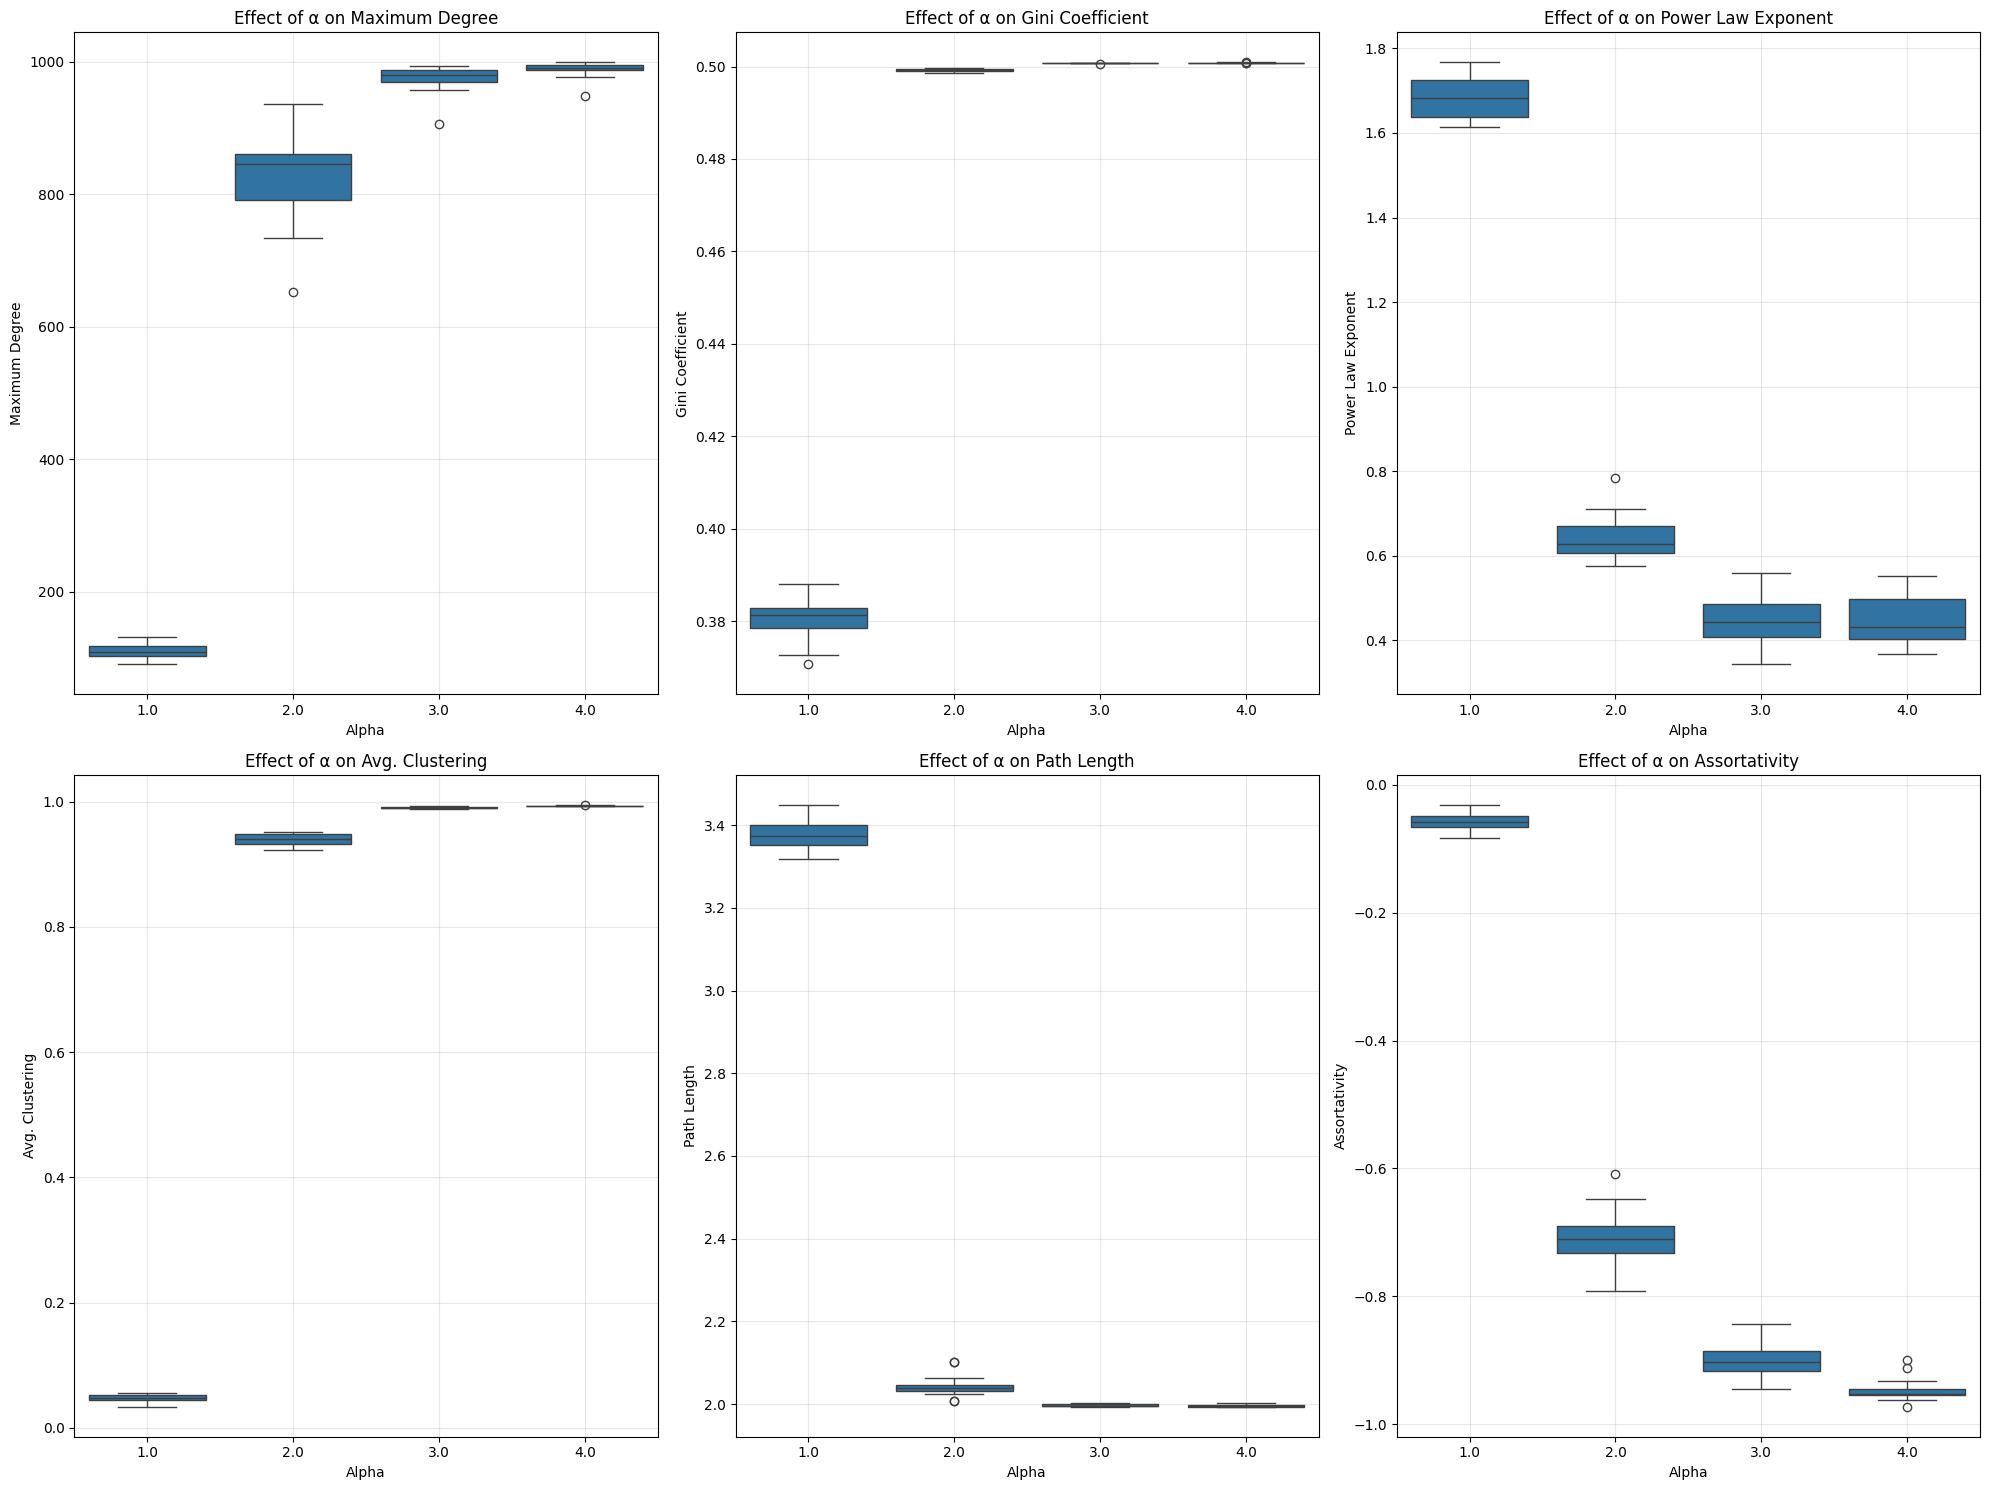

In [7]:
if __name__ == "__main__":
    results, summary, networks = main(final_nodes=1000, initial_nodes=10, edges_per_step=3, runs_per_model=20)